In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from nltk import word_tokenize
import boto3
from s3 import get_file
import re
import mglearn
import sklearn
import yellowbrick
from nltk.corpus import stopwords

In [2]:
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

In [3]:
s3 = boto3.resource('s3')
lyrics = get_file(s3,'s3ssp',download_file='NLP_Data/master_lyrics_audio_features.csv',rename_file='0320_2020_nlp.csv')

In [4]:
df = pd.read_csv(lyrics,sep='|',encoding='utf-8')
df_copy = df.copy().dropna()

In [5]:
df_copy = df_copy.drop(columns=['instrumentalness','key','mode','liveness','speechiness','time_signature'])

## Clean of stop words from NLTK and Github Song Stopwords Resource

In [6]:
df_copy.head()

,artist_uri,artist_name,track_name,track_uri,lyrics,acousticness,danceability,energy,valence,loudness,tempo
0,6vWDO969PvNqNYHIOW5v0m,Beyoncé,why don't you love me,5Ui8M6tfknhXo4MuGHt3Dy,"N-n-now , honey You sit 'Cause bumped ' head A...",0.0463,0.693,0.730,0.7410,-4.571,136.882
1,6vWDO969PvNqNYHIOW5v0m,Beyoncé,save the hero,5dhPqcLr5EcSd7Fe4fslCq,I lay awake night Sorrow fills eyes But I 'm s...,0.6730,0.551,0.467,0.1480,-10.364,116.966
2,6vWDO969PvNqNYHIOW5v0m,Beyoncé,broken-hearted girl,5dWTQXVHdoIsSLpEyS3woy,Youre I And I couldve But live So ? Youre I I ...,0.5030,0.336,0.424,0.1590,-7.203,82.149
3,6vWDO969PvNqNYHIOW5v0m,Beyoncé,lift ev'ry voice and sing - homecoming live,0QRxJvOohS8yiGC1n98uFM,He laughin ' flirting And n't care As matter r...,0.1240,0.127,0.409,0.0782,-13.089,79.904
4,6vWDO969PvNqNYHIOW5v0m,Beyoncé,no angel,4DActPOAtak2m8meZeMt3B,"This fans ( Uhu , uhu ) This destiny ( Uhu , u...",0.0424,0.571,0.466,0.5120,-9.153,111.580


In [7]:
check_playlist = df_copy[(df_copy['valence']>=.55) & (df_copy['energy']>=.60) 
                              & (df_copy['danceability']>=.50) & (df_copy['acousticness']>=.10)
                             ]

In [9]:
make_playlist = check_playlist.sample(20)

In [62]:
#Control Panel - Hyper Parameters

#Count Vectorizer
max_features = 500 #500
max_df = .015



#LDA
n_topics = 10  #10


#LDA Display
display_n_chunks = 2 #5
n_topics = 10        #20
n_words = 10       #5



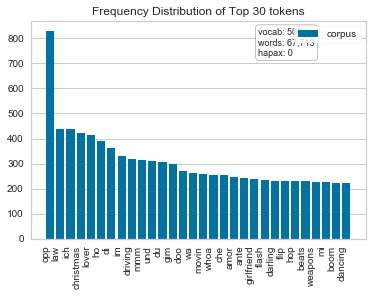

In [63]:
from sklearn.feature_extraction.text import CountVectorizer

from yellowbrick.text import FreqDistVisualizer

# Load the text data


vect = CountVectorizer(max_features=max_features, max_df=max_df,stop_words='english')
docs       = vect.fit_transform(df_demo['nltk_lyrics'])
features   = vect.get_feature_names()

visualizer = FreqDistVisualizer(features=features, orient='v',n=30)
visualizer.fit(docs)
visualizer.show()

In [64]:
#Count Vectorizer
vect = CountVectorizer(max_features=max_features, max_df=max_df,stop_words='english')
X = vect.fit_transform(df_demo['nltk_lyrics'])

## Topic Analysis

In [65]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_topics=n_topics, learning_method="batch",
                                max_iter=15, random_state=0)
# We build the model and transform the data in one step
# Computing transform takes some time,
# and we can save time by doing both at once
document_topics = lda.fit_transform(X)

print("lda.components_.shape: {}".format(lda.components_.shape))

# For each topic (a row in the components_), sort the features (ascending)
# Invert rows with [:, ::-1] to make sorting descending
sorting = np.argsort(lda.components_, axis=1)[:, ::-1]
# Get the feature names from the vectorizer
feature_names = np.array(vect.get_feature_names())

# Print out the 10 topics:
mglearn.tools.print_topics(topics=range(n_topics), feature_names=feature_names,
                           sorting=sorting, topics_per_chunk=display_n_chunks, n_words=n_words)





/Users/adamgoldstein/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


lda.components_.shape: (10, 500)
topic 0       topic 1       
--------      --------      
law           ho            
lover         doo           
beating       evil          
dem           weapons       
looking       hop           
mom           losing        
bag           somethin      
machine       record        
cuz           belong        
lying         chasing       


topic 2       topic 3       
--------      --------      
christmas     driving       
girlfriend    flash         
secret        boom          
praise        hada          
fallen        funky         
glad          boogie        
guy           christmas     
radio         joe           
rules         yesterday     
telling       dee           


topic 4       topic 5       
--------      --------      
mmm           ich           
spirit        im            
closer        und           
holy          di            
golden        che           
hole          gim           
searching     amor          
queen 

In [74]:
def playlist_element(topics=range(n_topics), feature_names=feature_names,
                           sorting=sorting, topics_per_chunk=display_n_chunks, n_words=n_words):
    playlists = []
    for i in range(0, len(topics), topics_per_chunk):
        # for each chunk:
        these_topics = topics[i: i + topics_per_chunk]
        # maybe we have less than topics_per_chunk left
        len_this_chunk = len(these_topics)
        # print topic headers
        #print(("topic {:<8}" * len_this_chunk).format(*these_topics))
        #print(("-------- {0:<5}" * len_this_chunk).format(""))
        # print top n_words frequent words
        for i in range(n_words):
            try:
                #print(("{:<14}" * len_this_chunk).format(
                #    *feature_names[sorting[these_topics, i]]))
                playlists.append(feature_names[sorting[these_topics, i]][0])
            except:
                pass
        print("\n")
    return playlists

In [75]:
playlists = playlist_element()

In [76]:
playlists[0]

'dance'

In [77]:
def create_ssp(n_words,playlists):
    playlist = []
    for x in range(n_words):
        playlist.append(playlists[x])
    return playlist
        
        
    

In [78]:
playlist = create_ssp(n_words,playlists)

In [79]:
playlist

['dance',
 'ooh',
 'care',
 'help',
 'goodbye',
 'babe',
 'boom',
 'waiting',
 'ba',
 'control']

## Rough Create SSP

In [170]:
def find_lyrics(lyrics,element,playlist_position):
    if(lyrics.find(element)!= -1):
        return playlist_position
    else:
        return None


In [176]:
def make_ssp(playlist):
    df_demo_ssp = df_demo
    ssp = []
    for slot in range(len(playlist)):
#reset to org state
        df_demo_ssp['playlist_index_{s}'.format(s=slot)] = df_demo_ssp.apply(lambda x: find_lyrics(x['lyrics']
                                                                            ,playlist[slot],slot),axis=1)
        x = df_demo_ssp.dropna(how='all')
        y = x[(x['valence'] == x['valence'].max())]
        z = y[(y['energy'] == y['energy'].max())]

        print(z.track_uri.values[0])
        ssp.append({'artist_name':z.artist_name.values[0],'track_name':z.track_name.values[0],'track_uri':z.track_uri.values[0],
                   'valence':y.valence.values[0],'energy':z.energy.values[0],'lyrics':z.lyrics.values[0]})

        df_demo_ssp = df_demo_ssp.drop(index=z.index)
    return ssp

In [177]:
ssp = make_ssp(playlist)
#playlist[0]

4huL7QhzO49SW3emj2v6x3
77ScDbg6pF84vc9WX25FAQ
4Htezs2THA2I8rE6wwtnJS
224k0iOwvyVVFGq7pcmekz
0mTc5pHScWNXwvQN0rfSHl
6f040TcZTtEW8LaYwUQLMP
12yYZ8vXzEcXG6XGwi1C8x
20AePDsEmKOiaTWYbKbeH5
4xJyoKoS3Sdy23k3uyOBpA
1Iz4JdDxglpnjXzMHlpnOp


In [178]:
df_ssp = pd.DataFrame(ssp)
df_ssp

,artist_name,energy,lyrics,track_name,track_uri,valence
0,Gary's Gang,0.638,Love dancing!!!... I've been calling for your ...,let's love dance tonight,4huL7QhzO49SW3emj2v6x3,0.980
1,Donovan,0.514,From the album donovan Dare to be different - ...,dare to be different,77ScDbg6pF84vc9WX25FAQ,0.980
2,Eugene McGuinness,0.527,"And I've been putting it about Step right up, ...",she paints houses,4Htezs2THA2I8rE6wwtnJS,0.978
3,883,0.950,La grande citt s'illumina gi con i neon e gli ...,viaggio al centro del mondo,224k0iOwvyVVFGq7pcmekz,0.975
4,The Dave Clark Five,0.835,"(I'm in pieces, bits and pieces) Since you lef...",bits and pieces - 2019 - remaster,0mTc5pHScWNXwvQN0rfSHl,0.974
5,Banda Los Recoditos,0.622,Si vieras como ando de preocupado aquÃ­ con un...,vieras como,6f040TcZTtEW8LaYwUQLMP,0.974
6,B*Witched,0.925,Oh Mickey You're so fine You're so fine You bl...,mickey,12yYZ8vXzEcXG6XGwi1C8x,0.973
7,Abra Moore,0.776,See I've been thinkin' it over It's all just a...,four leaf clover,20AePDsEmKOiaTWYbKbeH5,0.973
8,Brenda Lee,0.529,"Won't you come home, Bill Bailey, won't you co...",bill bailey,4xJyoKoS3Sdy23k3uyOBpA,0.973
9,Fine Young Cannibals,0.703,Never had the good things only money can buy. ...,don't look back,1Iz4JdDxglpnjXzMHlpnOp,0.972


## Visualization (Valence Curve, Energy Curve)

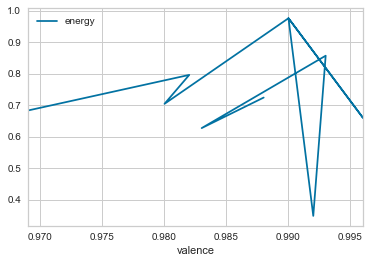

In [130]:
df_ssp.plot.line(x='valence',y='energy')

## Create Spotify Playlist

In [10]:
import requests
import json
import pandas as pd
import spotipy#authentication
import spotipy.util as util#authentication
from spotipy.oauth2 import SpotifyClientCredentials#authentication

In [11]:
cid = '049ade7215e54c63a2b628f3784dc407'
secret = '5d30770120ad4dbbabbb5ce538110e05'
redirect_uri = 'http://google.com/'
username = 'name'

In [15]:
#Authentication

scope = 'playlist-modify-private'
token_playlist = util.prompt_for_user_token(username, scope, client_id=cid, client_secret=secret, redirect_uri=redirect_uri)

if token_playlist:
    sp_playlist = spotipy.Spotify(auth=token_playlist)
else:
    print("Can't get token for", username)
    
#Authentication

scope = 'user-read-private'
token_user = util.prompt_for_user_token(username, scope, client_id=cid, client_secret=secret, redirect_uri=redirect_uri)

if token_user:
    sp_user = spotipy.Spotify(auth=token_user)
else:
    print("Can't get token for", username)



            User authentication requires interaction with your
            web browser. Once you enter your credentials and
            give authorization, you will be redirected to
            a url.  Paste that url you were directed to to
            complete the authorization.

        
Opened https://accounts.spotify.com/authorize?client_id=049ade7215e54c63a2b628f3784dc407&response_type=code&redirect_uri=http%3A%2F%2Fgoogle.com%2F&scope=playlist-modify-private in your browser


Enter the URL you were redirected to: https://www.google.com/?code=AQBFDPLo0HnmtpT_I7pT6FyOew_CrTlB1dYVWFdaHdzaFUAUs_NhjUh15HivWQfyzwQLw0fSn0jZFVLItSOscoj173PSI2DGmNL6SazLJjWuTbt8dMi3_uFoqyTiMBaO6AjYhcAlcP7nvd-_svtxesoxfasy7PHKU-veKurh5ZgnyZzD_qXxaCqnPiLmVl9RuIpPoCsNrYOb85WHOg4wMdE




            User authentication requires interaction with your
            web browser. Once you enter your credentials and
            give authorization, you will be redirected to
            a url.  Paste that url you wer

In [16]:
def get_user_id(url):
    try:
        resp = requests.get(url,headers={'Authorization': 'Bearer ' + token_user},
                             #data={"name": "SSP"}
                           )
        
        resp.raise_for_status()
    except requests.exceptions.HTTPError as err:
        print(err)
        
    
    response = resp.json()
    userid = response['id']
    
    return userid


In [17]:
user_id = get_user_id('https://api.spotify.com/v1/me')

In [18]:
identification = user_id
identification

'124399179'

In [19]:
playlist = sp_playlist.user_playlist_create(identification,'SSP_Ideal', public=False, description="Ideal SSP")

In [20]:
playlist

{'collaborative': False,
 'description': 'Ideal SSP',
 'external_urls': {'spotify': 'https://open.spotify.com/playlist/6vlZNMLF0TGkJlWdnWfObu'},
 'followers': {'href': None, 'total': 0},
 'href': 'https://api.spotify.com/v1/playlists/6vlZNMLF0TGkJlWdnWfObu',
 'id': '6vlZNMLF0TGkJlWdnWfObu',
 'images': [],
 'name': 'SSP_Ideal',
 'owner': {'display_name': 'Adam Goldstein',
  'external_urls': {'spotify': 'https://open.spotify.com/user/124399179'},
  'href': 'https://api.spotify.com/v1/users/124399179',
  'id': '124399179',
  'type': 'user',
  'uri': 'spotify:user:124399179'},
 'primary_color': None,
 'public': False,
 'snapshot_id': 'MSxjOGZmNWJhNmY1ZTYzMDFlMDUxMTg1ZTFkODY2Mzg4NjJhYTZjMjg4',
 'tracks': {'href': 'https://api.spotify.com/v1/playlists/6vlZNMLF0TGkJlWdnWfObu/tracks',
  'items': [],
  'limit': 100,
  'next': None,
  'offset': 0,
  'previous': None,
  'total': 0},
 'type': 'playlist',
 'uri': 'spotify:playlist:6vlZNMLF0TGkJlWdnWfObu'}

In [21]:
playlist_tracks = sp_playlist.user_playlist_add_tracks(identification,playlist['id'],make_playlist['track_uri'], position=None)

## unigrams

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {i}:".format(i=topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
#How many words per topic
no_top_words = 4
display_topics(nmf, tfidf_feature_names, no_top_words)